# Augmentation

1. Shift everything left/right (ph shift)
2. Shifting everything up and down.
3. Random shift up/down for each datapoint.

In [5]:
%load_ext autoreload
%autoreload 2

# Run if connected to remote Jupyter server
import os
# os.chdir('electrochemistry_sean_mcintosh/electrochem')
print(os.getcwd())

import wandb
import time
from easydict import EasyDict as edict
from random import seed
from random import randint
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical

from waylon_keras_utils import train_model
from waylon_layer_utils import AttentionLSTM


from utils import train, load_default_config, train_with_aug_kfold, \
                  train_with_aug

from electro_augmenter import ElectroAugmenter
from utils import load_X_y_from_columns, reshape_to_keras_format, \
                  scale_X_y

from constants import BEST_SW_COLS_MIN_VAL_LESS_THAN_30, \
                      LEAD_NO_50_COLS, \
                      COPPER_NO_500_COLS, \
                      CADMIUM_NO_50_COLS, \
                      HORIZONTAL_SYSTEMATIC_SHIFT_STD, \
                      VERTICAL_SYSTEMATIC_SHIFT_STD, \
                      VERTICAL_RANDOM_NOISE_SHIFT_STD, \
                      NOISE_SHIFT_SCALING_FACTOR

DEFAULT_SEED = 7
DATA_DIR = Path('../data')

sns.set()

cadmium = pd.read_csv(DATA_DIR / 'cadmium.csv', index_col=0)
copper = pd.read_csv(DATA_DIR / 'copper.csv', index_col=0)
lead = pd.read_csv(DATA_DIR / 'lead.csv', index_col=0)
seawater = pd.read_csv(DATA_DIR / 'seawater.csv', index_col=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/king/Google Drive/1 Projects/electrochemistry_sean_mcintosh/electrochem


# Shift Everything Left/Right

1. random number from gaussian dist. Will need to determine range (mean=0 but we don't know std, will probs be at least one and up to 15 or 20). Chop off that amount from the left/right and duplicate what was on the end. We may need a more sophisticated func but let's start with a constant. 

2. To determine std for Gaussian, look at data. Look at the peak on cadmium and look at how much the samples shift on each sample. Do the peaks fit a guassian dist? If it fits a constant

3. Can get the index that corresponds to the max value np.argmax() for the biggest peak in the set and then look at the dist of that. 

4. Can also verify by looking at the plots as well. 

## Max Value Location

- Cd: 501-600 range
- Cd mean: 553.4444444444445
- Cd std: 3.192390644124142
----
- Cu: 600-800 range (often bang on 700)
- Cu mean: 692.9130434782609
- Cu std: 3.34810840142234
----
- Pb: 550-650 range
- Pb mean: 604.2857142857143
- Pb std: 0.9583148474999098

Pb has the lowest std.

Go for std of 2.

### Cadmium

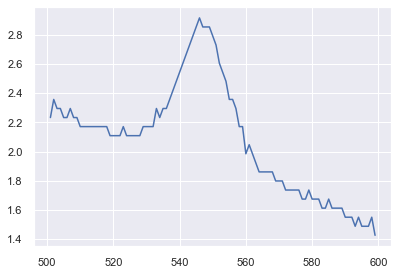

In [15]:
cd0 = cadmium.iloc[:, 1]
plt.plot(cd0[501:600])
plt.show()

In [17]:
cd0_slice = cd0[501:600]
cd0_slice.idxmax()

546

In [19]:
def get_cd_peak_idx(cd_series):
    cd_slice = cd_series[501:600]
    peak_idx = cd_slice.idxmax()
    return peak_idx

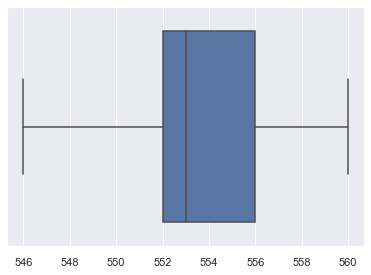

In [22]:
cd_peak_idxs = []
for col in cadmium.columns[1:]:
    peak_idx = get_cd_peak_idx(cadmium[col])
    cd_peak_idxs.append(peak_idx)
sns.boxplot(cd_peak_idxs)
plt.show()

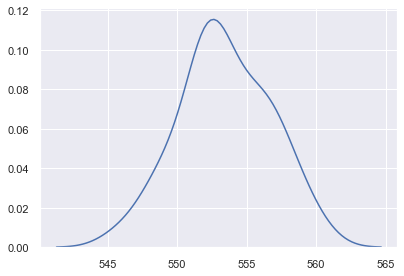

In [23]:
sns.kdeplot(cd_peak_idxs)

In [24]:
cd_mean = np.mean(cd_peak_idxs)
cd_std = np.std(cd_peak_idxs)
print('Cd mean:', cd_mean)
print('Cd std:', cd_std)

Cd mean: 553.4444444444445
Cd std: 3.192390644124142


#### Cadmium Drop 50 ppb Samples

In [12]:
cd_cols_no_50 = [col for col in cadmium if not '_50_ppb' in col]
cd_no_50 = cadmium.loc[:, cd_cols_no_50]
cd_no_50.to_csv(DATA_DIR / 'cadmium_no_50ppb.csv')

### Copper

Cu_1000_ppb_9


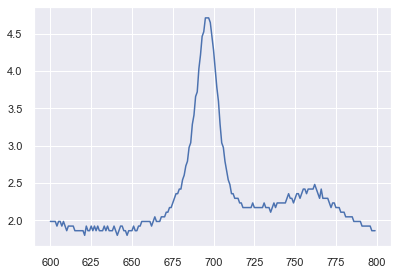

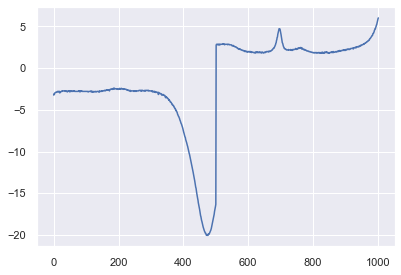

In [30]:
cu0 = copper.iloc[:, 10]
print(cu0.name)
cu_slice = cu0[600:800]
plt.plot(cu_slice)
plt.show()

In [33]:
def get_peak_idx(metal_series, slice):
    """
    * metal_series - a series
    * slice - list-like such that the first element is the lower bound
              and second is the upper bound of the slice
    """
    metal_slice = metal_series[slice[0]:slice[1]]
    peak_idx = metal_slice.idxmax()
    return peak_idx

In [40]:
def get_all_peak_idxs(metal, slice, name):
    peak_idxs = []
    
    for col in metal.columns[1:]:
        peak_idx = get_peak_idx(metal[col], slice)
        peak_idxs.append(peak_idx)
    
    sns.boxplot(peak_idxs)
    plt.show()

    sns.kdeplot(peak_idxs)
    plt.show()

    print_mean_and_std(peak_idxs, name)
    return peak_idxs

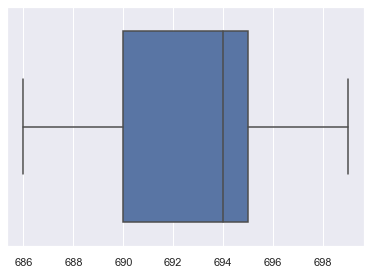

In [35]:
cu_peak_idxs = []
for col in copper.columns[1:]:
    cu_peak_idx = get_peak_idx(copper[col], (600, 800))
    cu_peak_idxs.append(cu_peak_idx)
sns.boxplot(cu_peak_idxs)
plt.show()

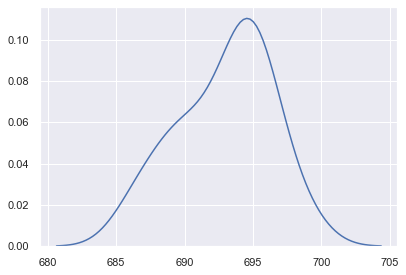

In [37]:
sns.kdeplot(cu_peak_idxs)
plt.show()

In [73]:
def print_mean_and_std(values, name):
    mean = np.mean(values)
    std = np.std(values)
    print(f'{name} mean:', mean)
    print(f'{name} std:', std)

In [39]:
print_mean_and_std(cu_peak_idxs, 'Cu')

Cu mean: 692.9130434782609
Cu std: 3.34810840142234


### Lead

In [51]:
lead_50_cols = [col for col in lead if '_50_ppb' in col]
lead_no_50 = lead.drop(lead_50_cols, axis=1)
lead_no_50.to_csv(DATA_DIR / 'lead_no_50ppb.csv')

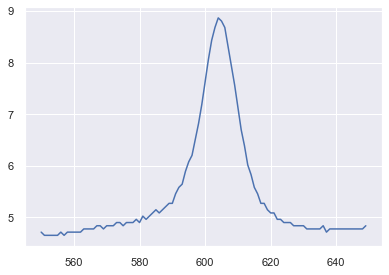

In [42]:
pb0 = lead.iloc[:, 15]
plt.plot(pb0[550:650])
plt.show()

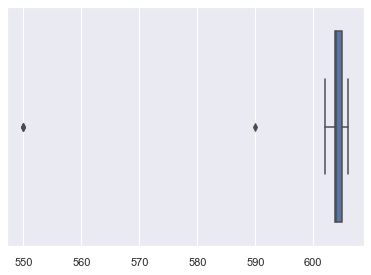

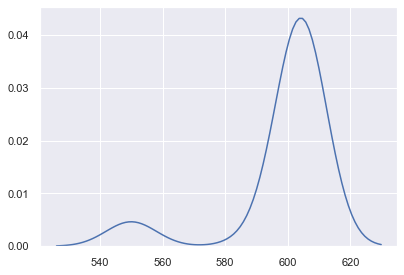

Pb mean: 598.75
Pb std: 15.900078616157845


In [52]:
pb_peak_idxs = get_all_peak_idxs(lead_no_50, (550, 650), 'Pb')

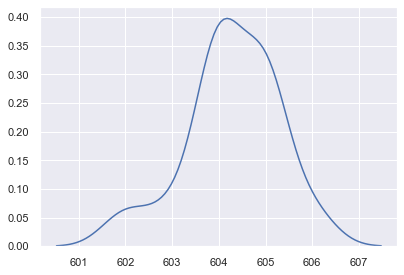

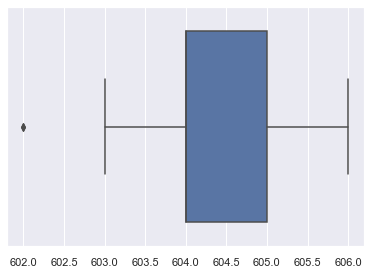

Pb mean: 604.2857142857143
Pb std: 0.9583148474999098


In [56]:
pb_peak_idxs_no_outliers = pb_peak_idxs[4:]

sns.kdeplot(pb_peak_idxs_no_outliers)
plt.show()

sns.boxplot(pb_peak_idxs_no_outliers)
plt.show()

print_mean_and_std(pb_peak_idxs_no_outliers, 'Pb')

In [129]:
sample = seawater_good.iloc[:, 0].values[:-1]
noise = np.random.choice([0, 1, 2])

In [202]:
# This works with positive numbers
a = np.array([0, 1, 2, 3, 4])
noise = np.random.choice([0, 1, 2])
print(f'Noise is: {noise}')
a = a[noise:]
last_elt = a[-1]
extra_vals = [last_elt for _ in range(noise)]
new_array = np.append(a, extra_vals)
print('Len new_array:', len(new_array))
new_array

Noise is: 2
Len new_array: 5


array([2, 3, 4, 4, 4])

In [231]:
std = 2
np.arange(std * -1, std+1)

array([-2, -1,  0,  1,  2])

In [233]:
int(3.94)

3

In [ ]:
a = np.array([0, 1, 2, 3, 4])
def _shift_left_right(self, std):
    """
    Given an array - a - and standard deviation, shift the array left/
    right by a max of int(std) positions. The first/last values are
    repeated to generate new elements. 
    
    Return the new array shifted left/right.
    """
    std = int(std)
    shift_range = np.arange(std * -1, std + 1)
    # Can shift a max of 2 points left or right
    noise = np.random.choice(shift_range)
    if noise >= 0:
        # Cut off first noise elements
        a = a[noise:]
        # Repeat last element noise times
        last_elt = a[-1]
        extra_vals = [last_elt for _ in range(noise)]
        # Append repeated last element to original array
        new_array = np.append(a, extra_vals)
    else:
        # Cut off last noise elements
        a = a[:noise]
        # Repeat first element noise times
        first_elt = a[0]
        new_first_vals = np.array([first_elt for _ in range(noise * -1)])
        # Add repeated first element to original array
        new_array = np.append(new_first_vals, a)
    return new_array

In [284]:
round(np.random.normal(0, std))

-1

In [230]:
a = np.array([0, 1, 2, 3, 4])
noise = np.random.choice([-2, -1])
print(f'Noise is: {noise}')
a = a[:noise]
first_elt = a[0]
new_first_vals = np.array([first_elt for _ in range(noise * -1)])
new_array = np.append(new_first_vals, a)
print('Len new_array:', len(new_array))
new_array

Noise is: -1
Len new_array: 5


array([0, 0, 1, 2, 3])

# Shift Entire Plot Up/Down

- For systematic, sample from Gaussian at 0, then add the std (determine experimentally with data). then add or subtract to every value in the array. 
- Take all good seawater samples, find mean value for each sample and look at variation in the mean. Will give you a sense of where the mean is. 
- THROW OUT BAD SEAWATER SAMPLES FIRST. ONLY USE CLEAN DATA FOR THIS. 

The distribution of the mean of the good quality seawater plots:
- Sw mean mean: -1.692777225779211
- Sw mean std: 0.4072484041424225

In [4]:
from constants import BEST_SW_COLS_MIN_VAL_LESS_THAN_30

seawater_good = seawater.loc[:, BEST_SW_COLS_MIN_VAL_LESS_THAN_30]
seawater_good.describe()

,SW0_72,SW0_24,SW0_48,SW0_22,SW0_75,SW0_25,SW0_47,SW0_58,SW0_27,SW0_78,...,SW0_60,SW0_20,SW0_77,SW0_64,SW0_71,SW0_19,SW0_52,SW0_68,SW0_54,SW0_43
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,...,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,-1.831971,-1.730533,-1.610788,-1.894317,-1.898028,-1.768634,-1.738451,-1.738451,-1.746368,-1.755254,...,-1.915284,-2.196959,-1.908420,-2.198691,-2.028969,-2.179207,-1.948438,-1.987219,-1.936810,-2.184403
std,6.840377,6.790189,6.531954,7.230019,7.161125,6.873134,6.846268,6.846268,6.855896,6.917066,...,7.340265,7.941433,7.449216,7.605208,7.699665,7.893300,7.233413,7.644868,7.700847,8.305385
min,-30.398376,-30.522451,-30.584488,-30.770601,-30.956713,-30.956713,-31.515051,-31.515051,-31.577088,-31.862250,...,-34.236300,-34.306738,-34.492851,-34.616926,-34.865076,-34.865076,-34.989151,-35.671563,-36.229901,-38.153063
25%,-0.496300,-0.434263,-0.713431,-0.496300,-0.496300,-0.434263,-0.682413,-0.682413,-0.434263,-0.437325,...,-0.393592,-0.434263,-0.434263,-0.992600,-0.434263,-0.434263,-0.310188,-0.434263,-0.434263,-0.434263
50%,0.744450,0.806488,0.806488,0.868525,0.868525,0.744450,0.744450,0.744450,0.744450,0.774690,...,0.712215,0.682413,0.744450,0.868525,0.806488,0.682413,0.558338,0.682413,0.806488,0.806488
75%,0.930563,1.054638,1.054638,1.178713,1.054638,1.054638,0.992600,0.992600,0.992600,0.993352,...,0.946496,0.992600,1.054638,1.116675,1.054638,0.930563,0.744450,0.992600,1.054638,1.054638
max,3.722250,3.660213,3.039838,4.528738,3.784288,3.474100,3.722250,3.722250,3.412063,3.898440,...,3.754747,3.846325,4.156513,3.846325,3.970400,3.225950,3.039838,3.536138,3.350025,3.722250


In [8]:
seawater_good_means = seawater_good.mean().values
sw_good_mean_of_means = np.mean(seawater_good_means)
sw_good_std_of_means = np.std(seawater_good_means)
print('Sw good mean of means:', sw_good_mean_of_means)
print('Sw good std of means:', sw_good_std_of_means)

Sw good mean of means: -1.9180533816217962
Sw good std of means: 0.1582920938558759


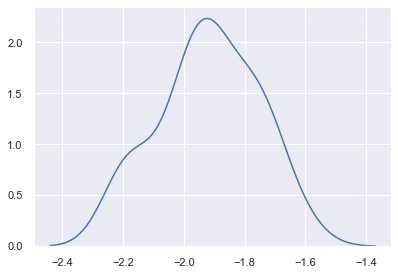

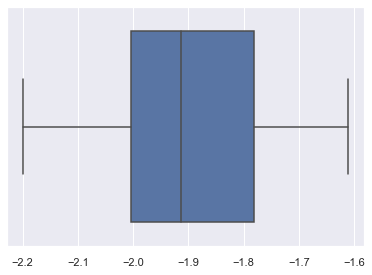

In [9]:
sns.kdeplot(seawater_good_means)
plt.show()

sns.boxplot(seawater_good_means)
plt.show()

In [ ]:
def _up_down_systematic_shift(a, std):
    """
    Given an array (a) and standard deviation (std), draw a number 
    from a Gaussian distribution mean=0 and std=std. Add this
    value to every element of a and return the new array.
    """
    systematic_noise = np.random.normal(0, std)
    new_array = a + systematic_noise
    return new_array

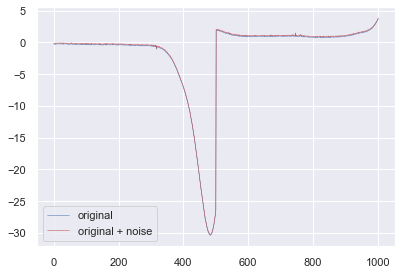

In [111]:
# This works
sample = seawater_good.iloc[:, 0].values[:-1]
stochastic_noise = np.random.normal(0, sw_good_std_of_means)
lw = 0.5
plt.plot(sample, 'b', lw=lw, label='original')
plt.plot(sample + stochastic_noise, 'r', lw=lw, label='original + noise')
plt.legend()
plt.show()

# Shift Each Point Up/Down Randomly

In [16]:
seawater_good.head()

,SW0_72,SW0_24,SW0_48,SW0_22,SW0_75,SW0_25,SW0_47,SW0_58,SW0_27,SW0_78,...,SW0_60,SW0_20,SW0_77,SW0_64,SW0_71,SW0_19,SW0_52,SW0_68,SW0_54,SW0_43
0,-0.310188,-0.310188,-0.372225,-0.248150,-0.310188,-0.248150,-0.310188,-0.310188,-0.310188,-0.293632,...,-0.212415,-0.248150,-0.310188,-0.992600,-0.248150,-0.248150,-0.186113,-0.24815,-0.24815,-0.310188
1,-0.310188,-0.310188,-0.310188,-0.310188,-0.310188,-0.248150,-0.310188,-0.310188,-0.248150,-0.224910,...,-0.268642,-0.310188,-0.310188,-0.992600,-0.310188,-0.248150,-0.186113,-0.24815,-0.24815,-0.310188
2,-0.310188,-0.310188,-0.310188,-0.248150,-0.310188,-0.186113,-0.310188,-0.310188,-0.248150,-0.274890,...,-0.206167,-0.310188,-0.310188,-1.054638,-0.248150,-0.248150,-0.186113,-0.24815,-0.24815,-0.248150
3,-0.248150,-0.310188,-0.372225,-0.248150,-0.310188,-0.248150,-0.310188,-0.310188,-0.248150,-0.206167,...,-0.249900,-0.248150,-0.248150,-0.992600,-0.186113,-0.248150,-0.186113,-0.24815,-0.24815,-0.248150
4,-0.248150,-0.248150,-0.310188,-0.248150,-0.310188,-0.186113,-0.310188,-0.310188,-0.186113,-0.281137,...,-0.187425,-0.310188,-0.248150,-0.992600,-0.248150,-0.186113,-0.248150,-0.24815,-0.24815,-0.248150


In [68]:
seawater_good.mean(axis=1)
# Leave out final value as it is the label column
std_at_each_voltage = seawater_good.std(axis=1).values[:-1]
std_first_200_voltages = std_at_each_voltage[:200]
mean_std_first_200_voltages = np.mean(std_first_200_voltages)

In [31]:
sample = seawater_good.iloc[:, 0].values[:-1]

In [42]:
np.random.normal(0, std_at_each_voltage)

array([-0.2879023 , -0.22926752, -0.40932933, ...,  0.23369656,
       -0.17969605, -0.61419928])

In [258]:
mean_std_first_200_voltages

0.21887254718166166

In [ ]:
def _up_down_random_shift(a, std, scale=0.1):
    """
    Given an array (a) and a standard deviation (std), draw len(a) 
    samples from a normal distribution mean=0, std=std. Multiply these
    values by scale and then add them to a to create a new_array.

    Note: We add a scaling parameter because the std likely has a
          meaning we would like to keep (e.g. the std of the mean of
          the first 200 samples). But this number is often too large
          to produce realisitic looking augmented samples, thus we
          scale them down.
    """
    random_noise = np.random.normal(0, std, len(a))
    new_array = a + (random_noise * scale)
    return new_array

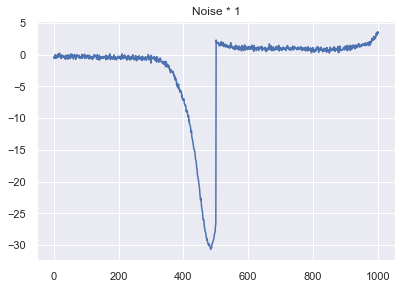

In [257]:
# THIS WORKS!
noise = np.random.normal(0, mean_std_first_200_voltages, len(sample))
scale = 1
plt.plot(sample + noise * scale)
plt.title(f'Noise * {scale}')
plt.show()

In [246]:
noise

array([-0.07466569,  0.11696479,  0.25036625, ...,  0.05032183,
       -0.09830235, -0.05008311])

# Testing ElectroAugmenter

In [394]:
from electro_augmenter import ElectroAugmenter
from utils import load_default_config, load_X_y_from_columns, \
                  scale_X_y, reshape_to_keras_format
from constants import BEST_SW_COLS_MIN_VAL_LESS_THAN_30, \
                      LEAD_NO_50_COLS, \
                      COPPER_NO_500_COLS, \
                      CADMIUM_NO_50_COLS, \
                      HORIZONTAL_SYSTEMATIC_SHIFT_STD, \
                      VERTICAL_SYSTEMATIC_SHIFT_STD, \
                      VERTICAL_RANDOM_NOISE_SHIFT_STD, \
                      NOISE_SHIFT_SCALING_FACTOR

In [436]:
from utils import _scale_val

print('Before scale', VERTICAL_SYSTEMATIC_SHIFT_STD)
after = _scale_val(VERTICAL_SYSTEMATIC_SHIFT_STD, 0, 1, -40, 40)
print('After scale', after)

Before scale 0.1582920938558759
After scale 0.5019786511731985


In [467]:
cols_to_use = {
    'Sw': BEST_SW_COLS_MIN_VAL_LESS_THAN_30,
    'Cu': COPPER_NO_500_COLS,
    'Cd': CADMIUM_NO_50_COLS,
    'Pb': LEAD_NO_50_COLS
    }

config = load_default_config()
config.cols_to_use = cols_to_use
config.data_processing.a = -1

# Load, scale, reshape
df_X_unscaled, df_y = load_X_y_from_columns(config)
df_X_scaled, df_y = scale_X_y(config, df_X_unscaled, df_y)
# X, y = reshape_to_keras_format(config, df_X_scaled, df_y)
X = df_X_scaled.values
y = to_categorical(df_y.values, num_classes=4)

In [508]:
print('X shape', X.shape)
print('y shape', y.shape)

X shape (108, 1002)
y shape (108, 4)


In [468]:
len(X)

108

[ 94  40  84 103  19  68  14  15  32  77   6  76  22  45  64  35  52  57
  26  69]


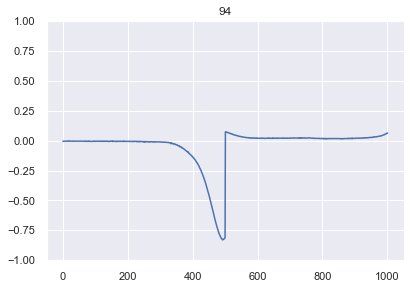

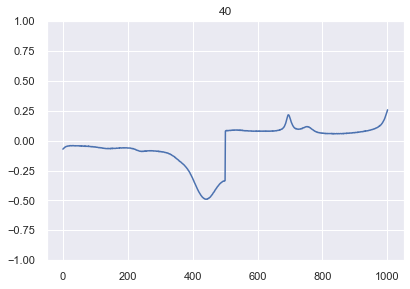

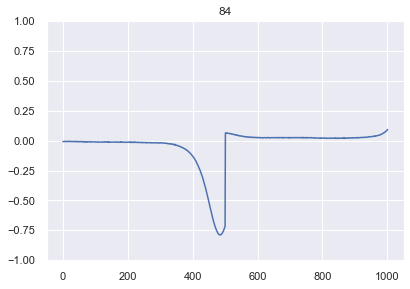

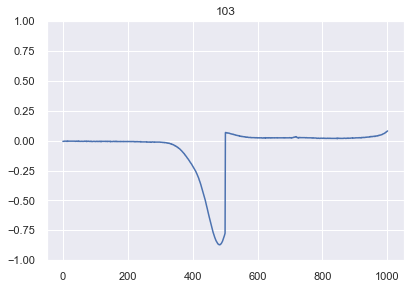

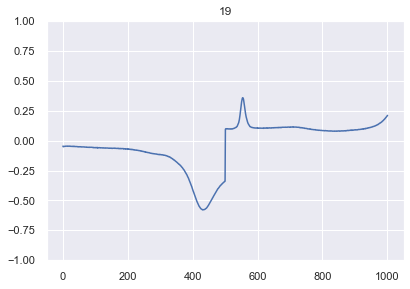

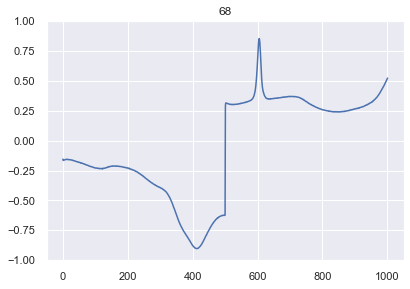

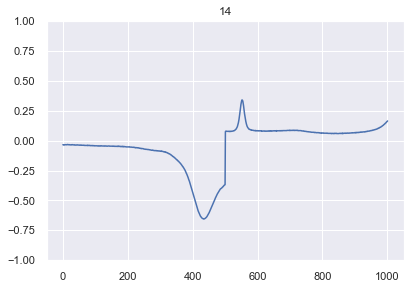

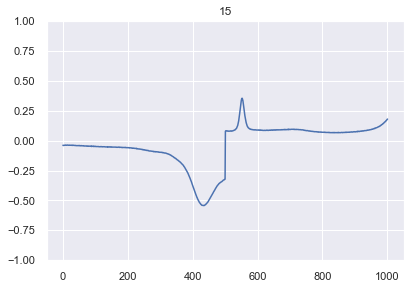

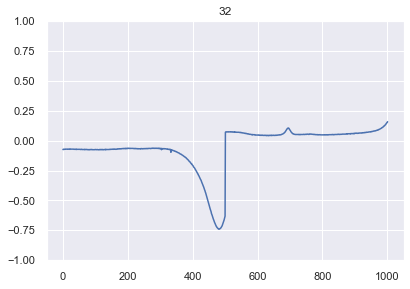

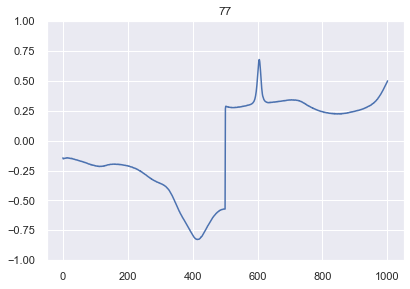

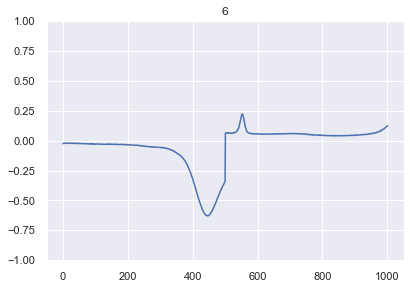

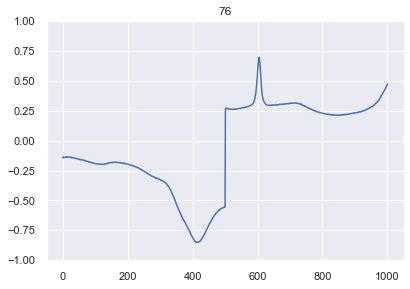

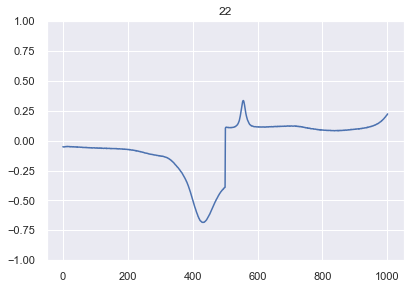

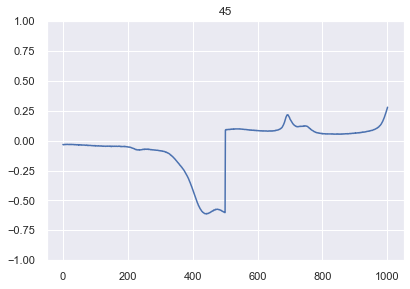

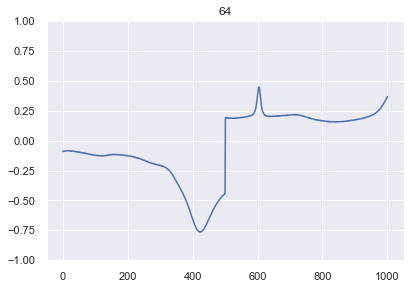

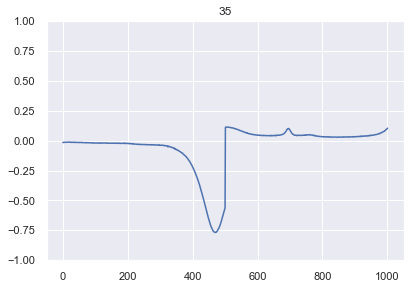

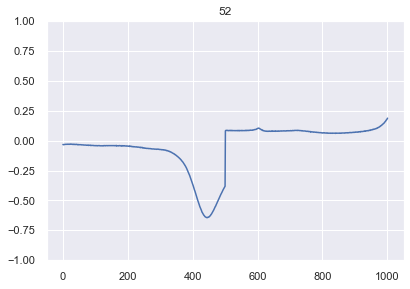

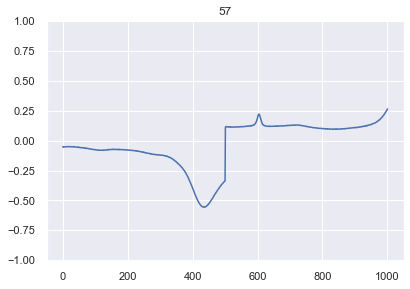

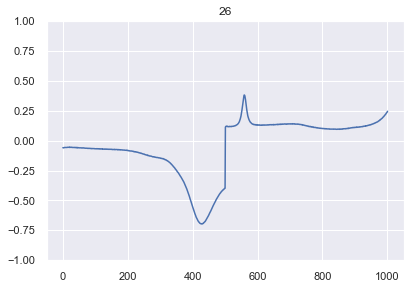

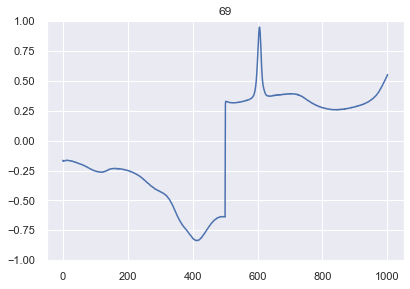

In [469]:
idxs = np.arange(len(X))
np.random.shuffle(idxs)
subset = idxs[:20]
print(subset)
for i in subset:
    plt.plot(X[i])
    plt.title(i)
    plt.ylim(-1, 1)
    plt.show()

In [502]:
scaling_factor = 0.02
aug = ElectroAugmenter(
    X, 
    y, 
    batch_size=20,
    horizontal_shift=HORIZONTAL_SYSTEMATIC_SHIFT_STD,
    vertical_shift=VERTICAL_SYSTEMATIC_SHIFT_STD*0.1,
    noise_shift=VERTICAL_RANDOM_NOISE_SHIFT_STD,
    noise_shift_scale=scaling_factor)

In [503]:
len(aug)

54

In [504]:
X_batch = aug[0][0]
y_batch = aug[0][1]
print('X_batch size', X_batch.shape)
print('y_batch size', y_batch.shape)

X_batch size (20, 1002)
y_batch size (20, 4)


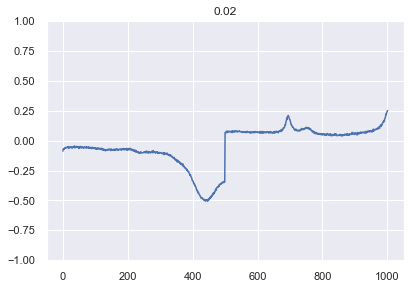

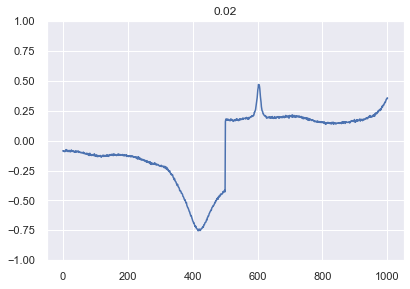

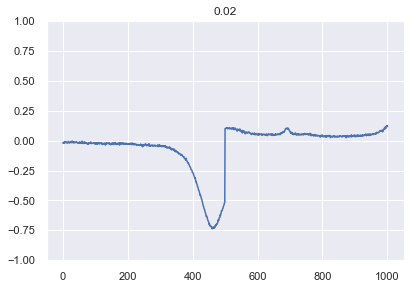

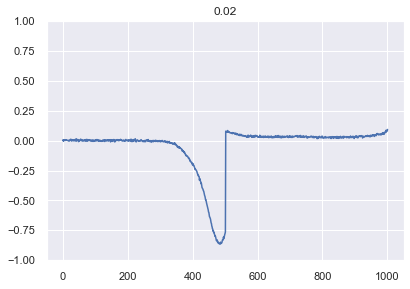

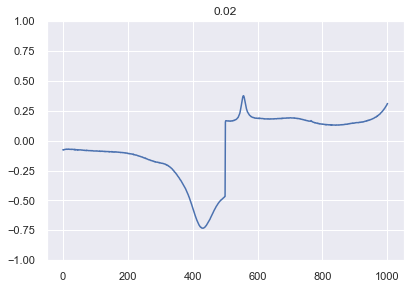

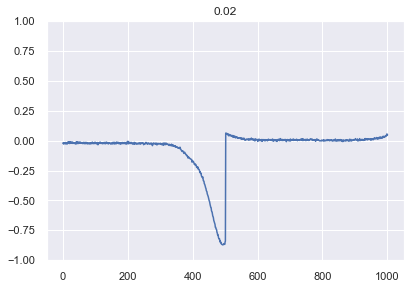

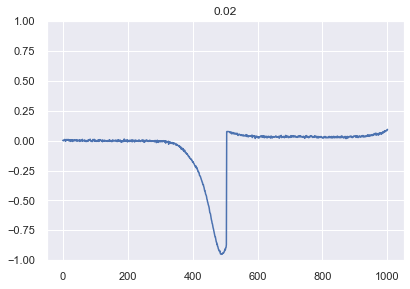

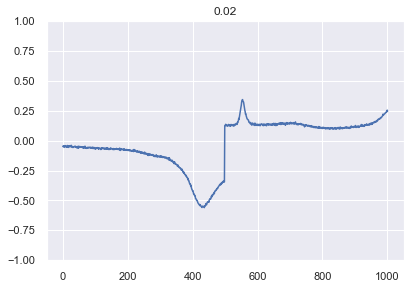

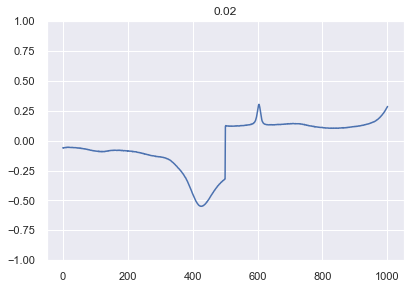

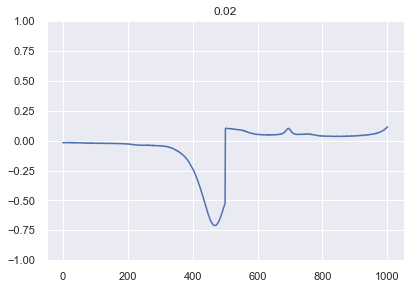

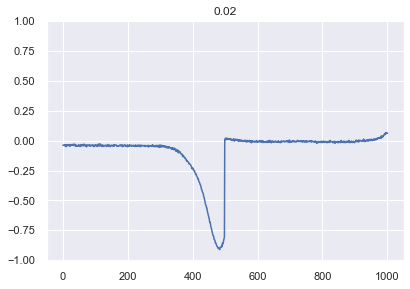

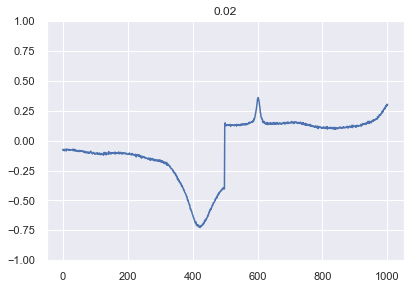

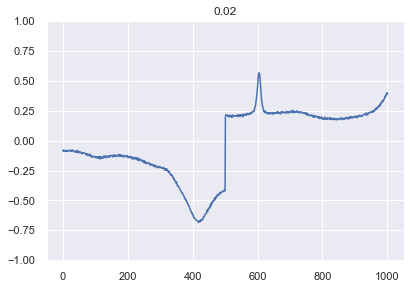

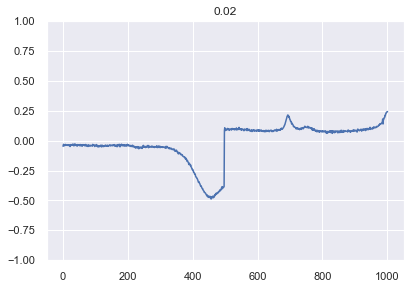

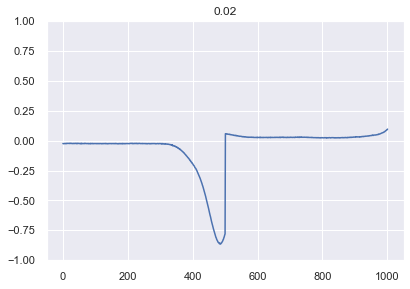

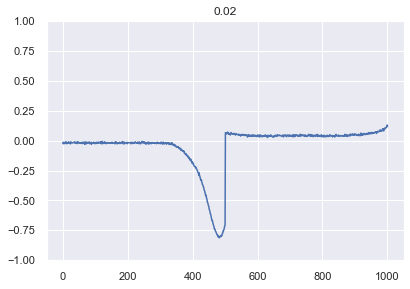

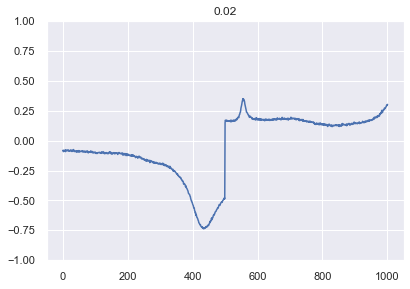

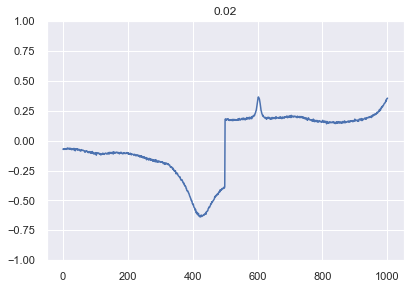

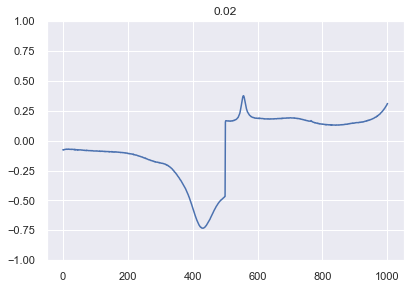

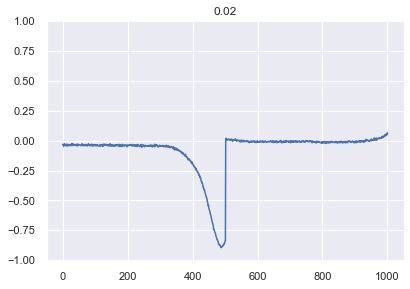

In [505]:
for x in X_batch:
    plt.plot(x)
    plt.title(scaling_factor)
    plt.ylim(-1, 1)
    plt.show()

In [507]:
X_batch = aug[0][0]
y_batch = aug[0][1]
print('X_batch size', X_batch.reshape(-1, 1, 1002).shape)
print('y_batch size', y_batch.shape)

X_batch size (20, 1, 1002)
y_batch size (20, 4)


# Training with ElectroAugmenter

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 3s 194ms/step - loss: 1.1993 - accuracy: 0.4078 - val_loss: 1.1105 - val_accuracy: 0.5909
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 0.9757 - accuracy: 0.6978 - val_loss: 0.9180 - val_accuracy: 0.7273
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 0.8263 - accuracy: 0.7122 - val_loss: 0.7982 - val_accuracy: 0.7273
Epoch 4/100
18/18 [==============================] - 1s 39ms/step - loss: 0.6924 - accuracy: 0.7378 - val_loss: 0.6812 - val_accuracy: 0.7273
Epoch 5/100
18/18 [==============================] - 1s 38ms/step - loss: 0.6034 - accuracy: 0.7567 - val_loss: 0.5942 - val_accuracy: 0.7273
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 0.5253 - accuracy: 0.7978 - val_loss: 0.5222 - val_accuracy: 0.8182
Epoch 7/100
18/18 [==============================] - 1s 47ms/step - loss: 0.4606 - accuracy: 0.8600 - val_loss: 0.4625 - val_accuracy: 0.8636
Epoch

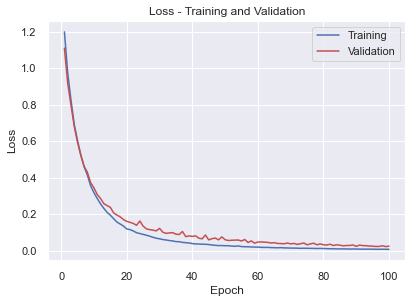

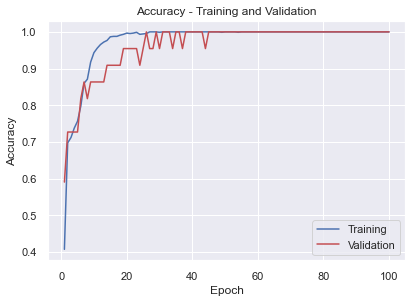

_runtime,94
_timestamp,1620939708
_step,0


_runtime,▁
_timestamp,▁
_step,▁


wandb run finished


Error: wandb.Image needs the PIL package. To get it, run "pip install pillow".

In [544]:
config = load_default_config(drop_50_ppb_cols=True)

history = train_with_aug(config)

# Train with Aug KFold

FOLD 1/5
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 2s 118ms/step - loss: 1.1574 - accuracy: 0.6233 - val_loss: 1.7210 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 50ms/step - loss: 0.9169 - accuracy: 0.7156 - val_loss: 1.4497 - val_accuracy: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 1s 53ms/step - loss: 0.7705 - accuracy: 0.6878 - val_loss: 1.5482 - val_accuracy: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 1s 54ms/step - loss: 0.6483 - accuracy: 0.7289 - val_loss: 1.3917 - val_accuracy: 0.0455
Epoch 5/100
18/18 [==============================] - 1s 49ms/step - loss: 0.5552 - accuracy: 0.7756 - val_loss: 1.2023 - val_accuracy: 0.5000
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 0.4757 - accuracy: 0.8133 - val_loss: 1.4045 - val_accuracy: 0.2727
Epoch 7/100
18/18 [==============================] - 1s 42ms/step - loss: 0.4126 - accuracy: 0.8667 - val_loss: 1.2675 - val_accuracy: 

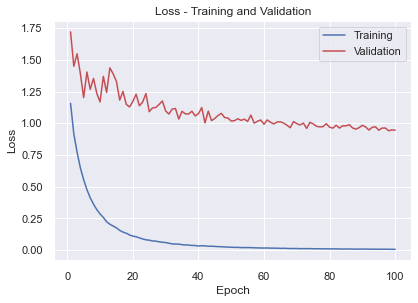

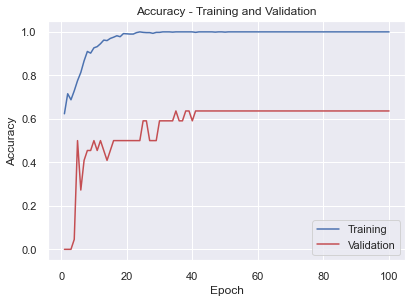

_runtime,104
_timestamp,1620941494
_step,2


_runtime,▁██
_timestamp,▁██
_step,▁▅█


wandb run finished
FOLD 2/5
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 2s 110ms/step - loss: 1.0865 - accuracy: 0.5544 - val_loss: 2.0824 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 39ms/step - loss: 0.7871 - accuracy: 0.7622 - val_loss: 2.1703 - val_accuracy: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 1s 56ms/step - loss: 0.6299 - accuracy: 0.8356 - val_loss: 2.3931 - val_accuracy: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 1s 48ms/step - loss: 0.5166 - accuracy: 0.8378 - val_loss: 2.2593 - val_accuracy: 0.0455
Epoch 5/100
18/18 [==============================] - 1s 44ms/step - loss: 0.4435 - accuracy: 0.8600 - val_loss: 2.2270 - val_accuracy: 0.0455
Epoch 6/100
18/18 [==============================] - 1s 41ms/step - loss: 0.3810 - accuracy: 0.8811 - val_loss: 2.3030 - val_accuracy: 0.0000e+00
Epoch 7/100
18/18 [==============================] - 1s 41ms/step - loss: 0.3372 - accuracy: 0.8833 - val_loss: 2.2403 - val_accura

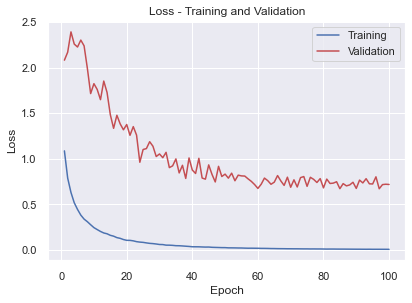

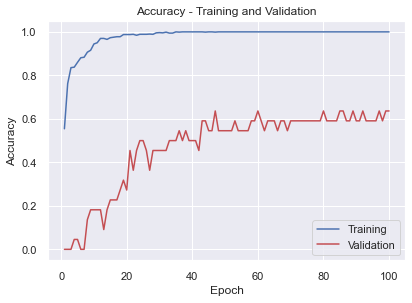

_runtime,99
_timestamp,1620941602
_step,2


_runtime,▁██
_timestamp,▁██
_step,▁▅█


wandb run finished
FOLD 3/5
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 2s 120ms/step - loss: 1.1757 - accuracy: 0.6267 - val_loss: 1.4112 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 49ms/step - loss: 0.8671 - accuracy: 0.8289 - val_loss: 1.5273 - val_accuracy: 0.1364
Epoch 3/100
18/18 [==============================] - 1s 43ms/step - loss: 0.6566 - accuracy: 0.8478 - val_loss: 1.9165 - val_accuracy: 0.0455
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 0.5169 - accuracy: 0.8456 - val_loss: 2.0696 - val_accuracy: 0.0909
Epoch 5/100
18/18 [==============================] - 1s 42ms/step - loss: 0.4249 - accuracy: 0.8567 - val_loss: 2.2568 - val_accuracy: 0.0455
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 0.3450 - accuracy: 0.8756 - val_loss: 2.4107 - val_accuracy: 0.0909
Epoch 7/100
18/18 [==============================] - 1s 45ms/step - loss: 0.2939 - accuracy: 0.9156 - val_loss: 2.6841 - val_accuracy: 0.0909
E

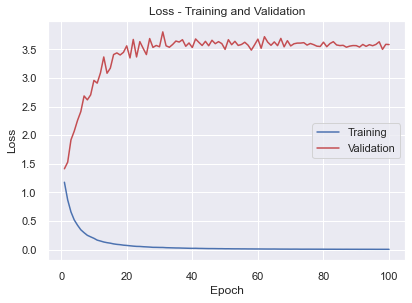

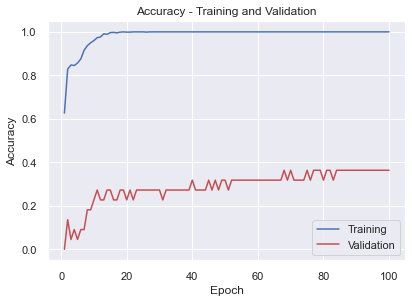

_runtime,101
_timestamp,1620941709
_step,2


_runtime,▁██
_timestamp,▁██
_step,▁▅█


wandb run finished
FOLD 4/5
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 3s 162ms/step - loss: 1.2297 - accuracy: 0.4578 - val_loss: 1.0835 - val_accuracy: 0.3333
Epoch 2/100
18/18 [==============================] - 1s 39ms/step - loss: 1.0485 - accuracy: 0.6100 - val_loss: 0.5875 - val_accuracy: 1.0000
Epoch 3/100
18/18 [==============================] - 1s 50ms/step - loss: 0.9022 - accuracy: 0.6444 - val_loss: 0.3319 - val_accuracy: 1.0000
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 0.7765 - accuracy: 0.6900 - val_loss: 0.2978 - val_accuracy: 1.0000
Epoch 5/100
18/18 [==============================] - 1s 56ms/step - loss: 0.6713 - accuracy: 0.7533 - val_loss: 0.1749 - val_accuracy: 1.0000
Epoch 6/100
18/18 [==============================] - 1s 52ms/step - loss: 0.5977 - accuracy: 0.7978 - val_loss: 0.1411 - val_accuracy: 1.0000
Epoch 7/100
18/18 [==============================] - 1s 52ms/step - loss: 0.5266 - accuracy: 0.8456 - val_loss: 0.1675 - val_accuracy: 1.0000
Epoch

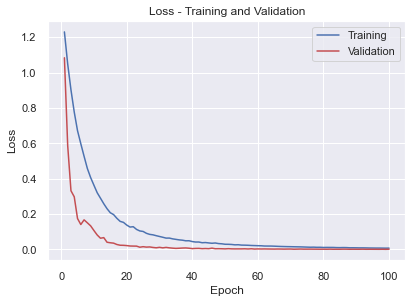

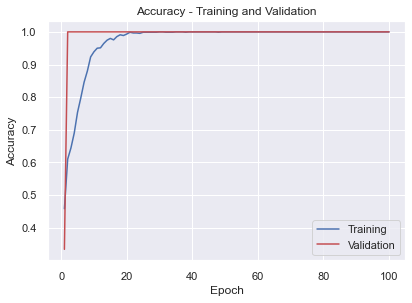

_runtime,111
_timestamp,1620941828
_step,2


_runtime,▁██
_timestamp,▁██
_step,▁▅█


wandb run finished
FOLD 5/5
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/100
18/18 [==============================] - 3s 147ms/step - loss: 1.1688 - accuracy: 0.3889 - val_loss: 1.8227 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 44ms/step - loss: 0.9911 - accuracy: 0.5456 - val_loss: 1.6126 - val_accuracy: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 1s 44ms/step - loss: 0.8919 - accuracy: 0.5633 - val_loss: 1.2212 - val_accuracy: 0.4762
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 0.8139 - accuracy: 0.6156 - val_loss: 0.9643 - val_accuracy: 0.9048
Epoch 5/100
18/18 [==============================] - 1s 43ms/step - loss: 0.7195 - accuracy: 0.7400 - val_loss: 0.7101 - val_accuracy: 1.0000
Epoch 6/100
18/18 [==============================] - 1s 43ms/step - loss: 0.6546 - accuracy: 0.7889 - val_loss: 0.5647 - val_accuracy: 1.0000
Epoch 7/100
18/18 [==============================] - 1s 47ms/step - loss: 0.5800 - accuracy: 0.8344 - val_loss: 0.4092 - val_accuracy: 1.00

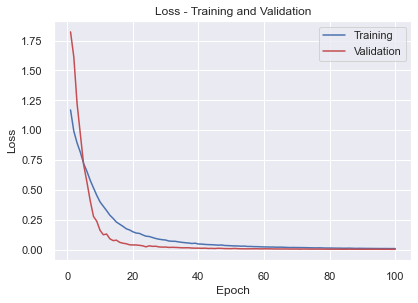

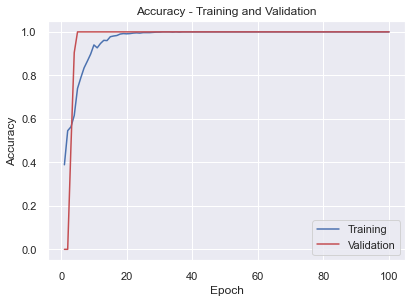

_runtime,106
_timestamp,1620941941
_step,2


_runtime,▁██
_timestamp,▁██
_step,▁▅█


wandb run finished


In [8]:
config = load_default_config(drop_50_ppb_cols=True)

history = train_with_aug_kfold(config)